# LiH ~ oo-pUCCD ~ prove di ottimizzazione

Determino l'initial point dei primi (8) parametri del circuito $\ket{\text{pUCCD}}$ eseguendo una prima volta VQE. 
Dopodiché le alternative sono due:
- fissare i primi parametri e ottimizzare solo i (15) $k$ orbitali
- ottimizzare ogni volta tutti i parametri

in questo programma si adotta la prima strategia. 
Il tempo di esecuzione è di circa 1 ora.

In [5]:
from functools import partial 
from time import time
import matplotlib.pyplot as plt
from pyscf import scf, fci

from subroutines import *

# Array distanze e energie
arr_distance = np.arange(0.7, 3.95, 0.25)
# (0.75, 4.05, 0.15) così sono 22 -> se 7 sono 5min mi aspetto ≈20 min
# (0.7, 3.95, 0.25) così 13
# (0.8, 3.95, 0.45) così sono 7 punti 8 min e mezzo
arr_ground_energy = {
    'FCI': [],
    'pUCCD': [],
    'oo-pUCCD': []
}
arr_results = []
arr_partial_energies = []
arr_interpreted = []

# 7 punti ~ SLSQP(ftol=1E-04, eps=1.5E-07) ~ 7min 20s ~ en primo punto -7.632234326577571
# X 7 punti ~ COBYLA(tol=1E-04) ~ >2min solo per il primo punto ~ en primo punto un pelino meglio -7.632300509311506
# 7 punti ~ SLSQP(ftol=1E-03, eps=1.5E-06) ~ 5min ~ en primo punto -7.632234326577581
# 7 punti ~ L_BFGS_B(eps=1.5E-06) ~ 5min ~ en primo punto -7.631187115280563 (male: uguale a pUCCD) ~ anche eps=1.5E-07 e -08

In [6]:
# punto di partenza degli optimizer
oo_starting_point = [ 3.23322778e-02,  4.36404671e-04,  1.37779855e-07,  3.96951039e-08,
                     -7.88745039e-04, -4.05058769e-02,  9.88076074e-10,  2.84742901e-10,
                      1.33658206e-02, -1.34882454e-11, -3.81397555e-12, -3.84563936e-01,
                     -2.76888454e-14,  7.94063378e-12,  2.26076217e-12 ]

puccd_starting_point = [ 3.13848286,  3.14021229,  3.14300319,  0.00368584,  
                         0.00401459, -3.18725922, -3.09542256, -3.24284134]

from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
# scelta dell'optimizer
opt = SLSQP(ftol=1E-03, eps=1.5E-06)

for distance in arr_distance:
    # definisco un array per contenere le energie parziali a questa distanza
    par_en = []
    
    print('- - - - - - - - - - - -', distance, '- - - - - - - - - - - -')
    # 0: FCI
    LiH = "Li 0 0 0; H 0 0 " + str(distance)
    basis = 'sto3g'
    
    ''' Integrals'''
    mol = gto.M(atom=LiH, basis=basis)

    cm  = scf.RHF(mol)
    cm.kernel() 
    fci_calc = fci.FCI(cm)
    e_FCI = fci_calc.kernel()[0]
    arr_ground_energy['FCI'].append(e_FCI)
    
    print('FCI: ', e_FCI)
    
    two_electron_integrals = mol.intor('int2e') # , aosym='s8') opzioni di simmetria
    one_electron_integrals = mol.intor("int1e_kin") + mol.intor("int1e_nuc")
    
    # 1: pUCCD
    problem = generate_problem(LiH, basis)
    puccd = generate_puccd(problem)
    start_time = time()
    puccd_result = compute_puccd_optimal(puccd, problem,ini=puccd_starting_point, opt=opt) 
    eval_time = time() - start_time
    # store optimal point for next distance
    puccd_starting_point=puccd_result.optimal_point
    # and assign parameters
    assigned_puccd = puccd.assign_parameters(puccd_result.optimal_parameters)
    puccd_interpreted = problem.interpret(puccd_result)
    puccd_energy = puccd_interpreted.groundenergy + puccd_interpreted.nuclear_repulsion_energy
    arr_ground_energy['pUCCD'].append(puccd_energy)
    
    print('pUCCD: ', puccd_energy, '| tempo: ', eval_time)
    
    # 2: oo-pUCCD
    rotations = create_orbital_rotation_list(puccd)
    excitations = convert_rotations_list(rotations)
    oo_puccd = generate_oo_puccd(assigned_puccd, problem, excitations)

    # SOLVE
    vqe_solver = VQE(Estimator(), oo_puccd, opt)
    # l'ottimizzazione parte dall'optimal value della distanza precedente
    vqe_solver.initial_point = oo_starting_point

    energy_evaluation = partial(energy_evaluation_oo, 
                                problem, 
                                one_electron_integrals,
                                two_electron_integrals,
                                vqe_solver, 
                                rotations, 
                                0,
                                par_en # ad ogni ottimizzazione viene salvata l'energia
                                )

    # setto bounds default
    bounds = [ [-np.pi,np.pi] for _ in range(oo_puccd.num_parameters) ]

    start_time = time()
    
    # minimization
    opt_result = vqe_solver.optimizer.minimize(
        fun=energy_evaluation, x0=oo_starting_point, bounds=bounds
    )
        
    eval_time = time() - start_time
    
    result = VQEResult()
    result.optimal_point = opt_result.x
    result.optimal_parameters = dict(zip(vqe_solver.ansatz.parameters, opt_result.x))
    result.optimal_value = opt_result.fun
    result.cost_function_evals = opt_result.nfev
    result.optimizer_time = eval_time
    result.eigenvalue = opt_result.fun + 0j
    
    oo_interpreted = problem.interpret(result)
    oo_energy = oo_interpreted.groundenergy + oo_interpreted.nuclear_repulsion_energy
    
    arr_ground_energy['oo-pUCCD'].append(oo_energy)
    
    
    
    
    print('oo-pUCCD: ', oo_energy, '| tempo: ', eval_time)
    
    # immagazzino tutto
    starting_point = opt_result.x
    arr_results.append(result)
    arr_interpreted.append(oo_interpreted)
    arr_partial_energies.append(par_en)
    

- - - - - - - - - - - - 0.7 - - - - - - - - - - - -
converged SCF energy = -7.48594487054545
FCI:  -7.505051766852393
pUCCD:  -7.502076674935379 | tempo:  2.734912633895874


/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_27392/839783028.py:59: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), oo_puccd, opt)


oo-pUCCD:  -7.502994144635435 | tempo:  10.350852012634277
- - - - - - - - - - - - 0.95 - - - - - - - - - - - -
converged SCF energy = -7.73952973656182
FCI:  -7.756886025844563
pUCCD:  -7.7538200490757445 | tempo:  2.519761085510254
oo-pUCCD:  -7.755008253117706 | tempo:  10.945099115371704
- - - - - - - - - - - - 1.2 - - - - - - - - - - - -
converged SCF energy = -7.83561582555691
FCI:  -7.852430853195908
pUCCD:  -7.849097003707441 | tempo:  2.3346381187438965
oo-pUCCD:  -7.850368176466458 | tempo:  10.211755990982056
- - - - - - - - - - - - 1.45 - - - - - - - - - - - -
converged SCF energy = -7.86256778554179
FCI:  -7.8809823145799855
pUCCD:  -7.877022108318632 | tempo:  2.6315338611602783
oo-pUCCD:  -7.8783169336733065 | tempo:  10.34430480003357
- - - - - - - - - - - - 1.7 - - - - - - - - - - - -
converged SCF energy = -7.85714496020382
FCI:  -7.879433516564259
pUCCD:  -7.874033561168982 | tempo:  2.5371599197387695
oo-pUCCD:  -7.875579939353496 | tempo:  9.91932487487793
- - - - 

plot

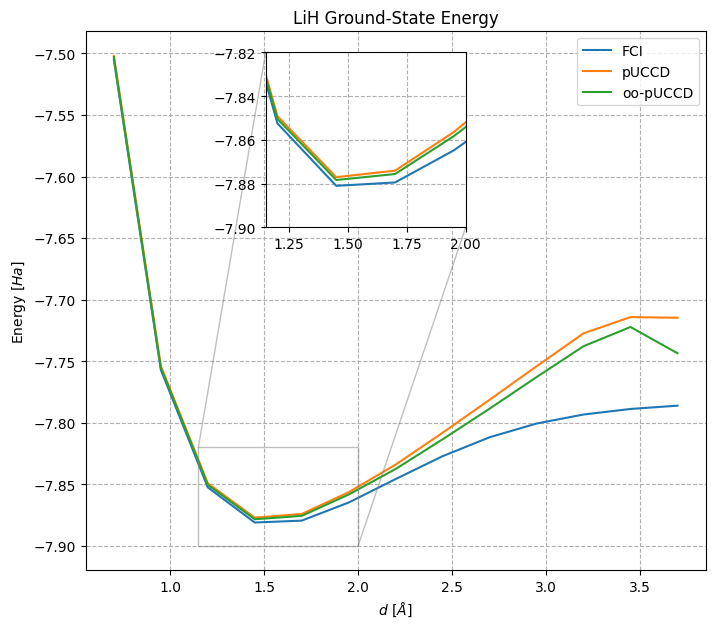

In [7]:
method = ['FCI', 'pUCCD', 'oo-pUCCD']

# Zoom sul minimo 1.25<x<1.8 e -7.9<y<-7.85
fig, ax = plt.subplots(figsize=[8, 7])
                       
for met in method:  
    plt.plot(arr_distance, arr_ground_energy[met], label=met)

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()

# Aggiungi un inset con zoom
# [x0, y0, width, height] specifica la posizione e dimensione del riquadro
ax_inset = plt.axes([.35, .6, .25, .25]) 


# Grafico dentro il grafico (zoom)
'''
for met in method:  
    ax_inset.plot(arr_distance, arr_ground_energy[met])
'''

# Imposta i limiti di zoom
ax_inset.axis(xmin=1.15,xmax=2.)
ax_inset.axis(ymin=-7.9,ymax=-7.82)

for met in method:  
    ax_inset.plot(arr_distance, arr_ground_energy[met], label=met)


# Aggiungi griglia nel grafico piccolo
ax_inset.grid(linestyle='--')
ax.indicate_inset_zoom(ax_inset)

plt.show()

# Grafici convergenza

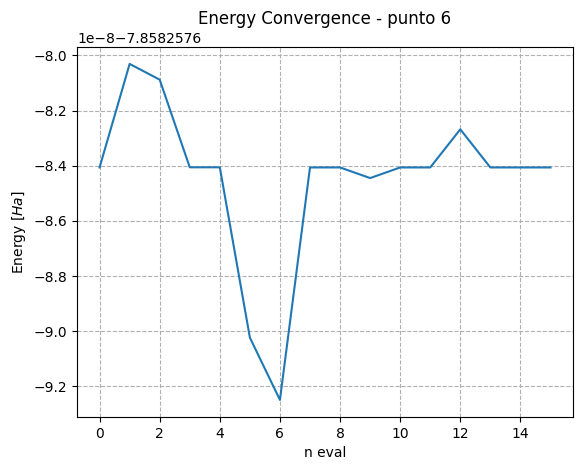

In [9]:
# shifto le energie parziali con nuclear repulsion

shiftato = [x + arr_interpreted[5].nuclear_repulsion_energy for x in arr_partial_energies[5]]

plt.plot(range(len(arr_partial_energies[5])), shiftato)

plt.title("Energy Convergence - punto 6")
plt.xlabel(r"n eval")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
#plt.legend()
plt.show()